In [ ]:
!pip install grad-cam
!pip install torcheval
!pip install torchmetrics
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=0c01f05f718b35d46914d2a2f89190cba9c9e54c3249c090935c786249c9c074
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from IPython.display import display
from torcheval.metrics.functional import binary_auprc
from torchmetrics import PrecisionRecallCurve
import albumentations as A
     

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
model_ft = torch.load("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/models/97%BBMalariaMobileNetV3.pt")
model_ft.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
malariadata = []
for filename in os.listdir("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/images/train/Malaria"):
  if filename.endswith("png") or filename.endswith("jpg"):
    malariadata.append((filename, "train"))
for filename in os.listdir("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/images/val/Malaria"):
  if filename.endswith("png") or filename.endswith("jpg"):
    malariadata.append((filename,"val"))

In [ ]:
print(len(malariadata))

1148


malariadata = [(img_name, train), (image_name, train), (image_name, val)]

[imagename, imagename, imagename]

In [ ]:
malaria_data_in_malaria_sam = []
for filename in os.listdir("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/malaria_SAM"):
  for i in malariadata:
    if filename == i[0]:
      malaria_data_in_malaria_sam.append((filename,i[1]))



In [ ]:
print(len(malaria_data_in_malaria_sam))

919


In [ ]:

def auc_judd(gt, pred):

    gt_binary = np.where(gt >= 0.5, 1, gt)
    gt_binary = np.where(gt_binary < 0.5, 0.0, gt_binary)
    
    thresholds = []

    for i in range(0, gt_binary.shape[0]):
        for j in range(0, gt_binary.shape[1]):
            if gt_binary[i][j] > 0.5:
                thresholds.append(pred[i][j])
    
    num_fixations = len(thresholds)
    area = []
    area.append((0.0, 0.0))


    for thresh in thresholds:
        temp = np.zeros(pred.shape)
        temp[pred >= thresh] = 1

        #print("Temp: ", np.add(temp, gt_binary))

        num_overlap = np.where(np.add(temp, gt_binary) == 2)[0].shape[0]
        tp = num_overlap/num_fixations

        fp = (np.sum(temp) - num_overlap)/((np.shape(gt_binary)[0] * np.shape(gt_binary)[1]) - num_fixations)

        area.append((round(fp, 4), round(tp, 4)))

    
    area.append((1.0, 1.0))



    area.sort(key = lambda x:x[0])
    tp_list = [x[1] for x in area]
    fp_list = [x[0] for x in area]

    print("AUC Judd: ", np.trapz(np.array(tp_list), np.array(fp_list)))

In [ ]:
# Load annotations into dictionaries for lookup
import json

f = open("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/test.json")
f2 = open("/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/training.json")

test_annotations = json.load(f)
training_annotations = json.load(f2)

annotations_dict = {}
size_dict = {}

for i in test_annotations:
    image_name = i['image']['pathname'].split('/')[-1]
    annotations_dict[image_name] = i['objects']
    size_dict[image_name] = {'r': i['image']['shape']['r'], 'c': i['image']['shape']['c']}
for i in training_annotations:
    image_name = i['image']['pathname'].split('/')[-1]
    annotations_dict[image_name] = i['objects']
    size_dict[image_name] = {'r': i['image']['shape']['r'], 'c': i['image']['shape']['c']} 

In [ ]:
annotations_dict["446734b7-6bc9-4a66-a3a0-49f6aa90db33.jpg"]

[{'bounding_box': {'minimum': {'r': 850, 'c': 977},
   'maximum': {'r': 975, 'c': 1108}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 1034, 'c': 1206},
   'maximum': {'r': 1165, 'c': 1339}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 117, 'c': 897},
   'maximum': {'r': 234, 'c': 1042}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 577, 'c': 1235},
   'maximum': {'r': 696, 'c': 1370}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 1223, 'c': 1037},
   'maximum': {'r': 1368, 'c': 1177}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 806, 'c': 1379},
   'maximum': {'r': 945, 'c': 1524}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 19, 'c': 676},
   'maximum': {'r': 152, 'c': 819}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 1053, 'c': 1394},
   'maximum': {'r': 1167, 'c': 1531}},
  'category': 'red blood cell'},
 {'boun

446734b7-6bc9-4a66-a3a0-49f6aa90db33.jpg


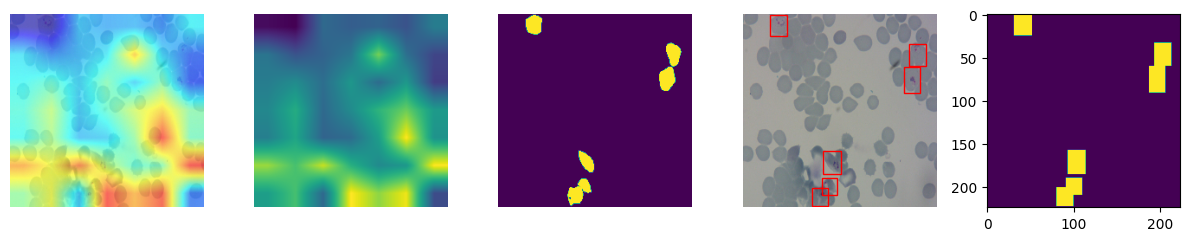

SAM Segmentation Results: 
AUC Judd:  0.34608763
AUPRC:0.029305921867489815

Dataset Bbox Segmentation Results: 
AUC Judd:  0.374061115
AUPRC:0.047849804162979126
44b4a765-104e-4182-8871-e933c83c91ef.png


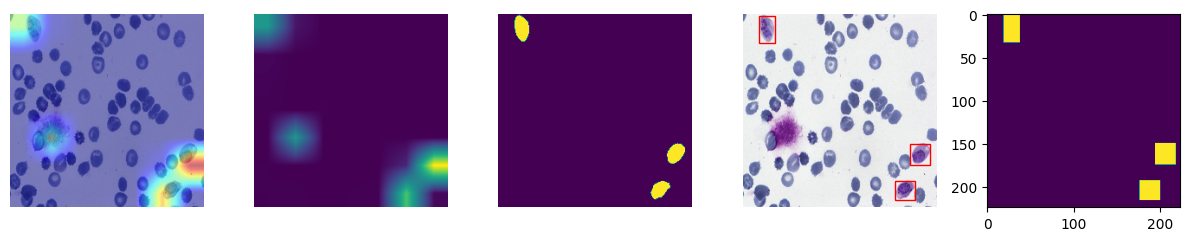

SAM Segmentation Results: 
AUC Judd:  0.9538503299999999
AUPRC:0.1807660013437271

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9547281249999998
AUPRC:0.2904447615146637
441d7843-b20b-4c10-84e3-e6d32621e880.png


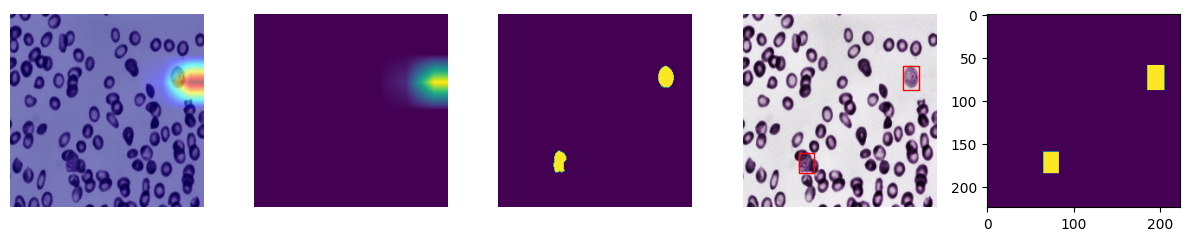

SAM Segmentation Results: 
AUC Judd:  0.61947739
AUPRC:0.09796936064958572

Dataset Bbox Segmentation Results: 
AUC Judd:  0.6388052750000001
AUPRC:0.1571306735277176
445d0db9-e830-4ceb-a845-b23d819e6097.png


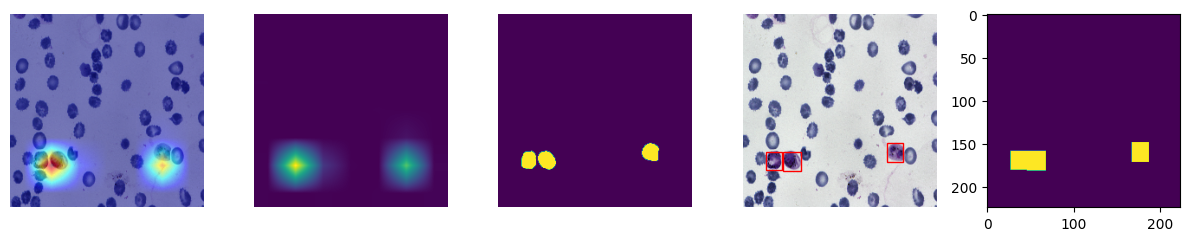

SAM Segmentation Results: 
AUC Judd:  0.98279507
AUPRC:0.4256797432899475

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9847562649999998
AUPRC:0.6257206797599792
452482bc-24a3-413e-ba03-fad4c9d61f3c.png


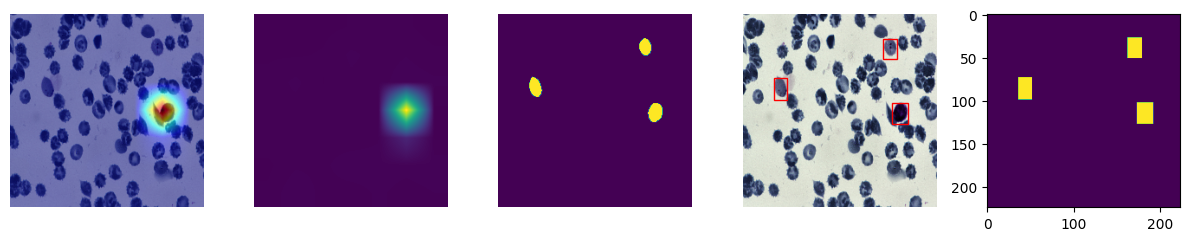

SAM Segmentation Results: 
AUC Judd:  0.7805974499999999
AUPRC:0.251413494348526

Dataset Bbox Segmentation Results: 
AUC Judd:  0.76766289
AUPRC:0.2778876721858978
45ac9409-5537-44ed-90cd-5c8a1ae0e1e0.png


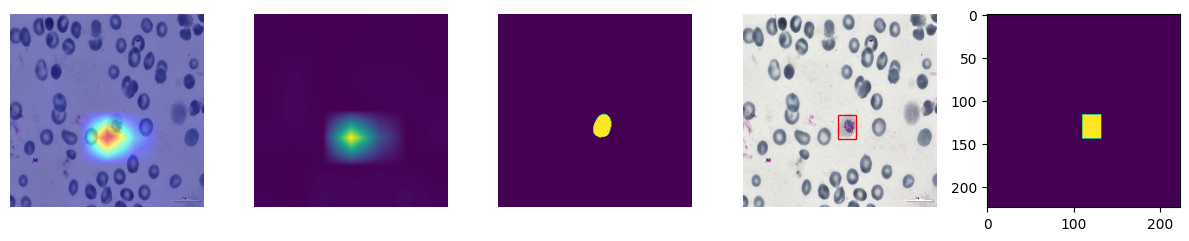

SAM Segmentation Results: 
AUC Judd:  0.9826156300000001
AUPRC:0.22816401720046997

Dataset Bbox Segmentation Results: 
AUC Judd:  0.983274545
AUPRC:0.3496524393558502
45f18ac0-f097-4b20-a99d-8837cf488822.png


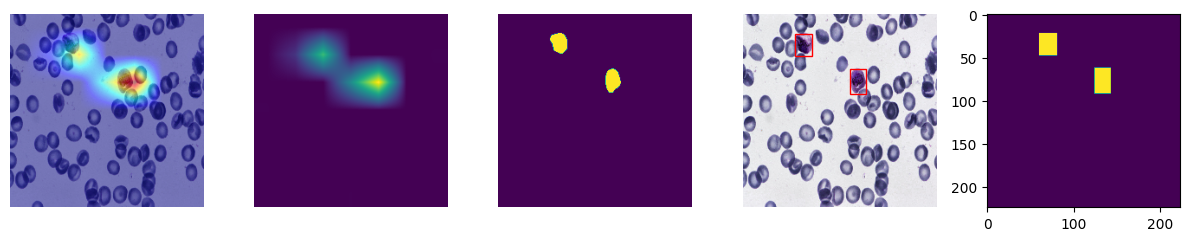

SAM Segmentation Results: 
AUC Judd:  0.968962135
AUPRC:0.2989336848258972

Dataset Bbox Segmentation Results: 
AUC Judd:  0.973179575
AUPRC:0.42852604389190674
45651e76-4bd0-45e5-895b-edec65f51987.png


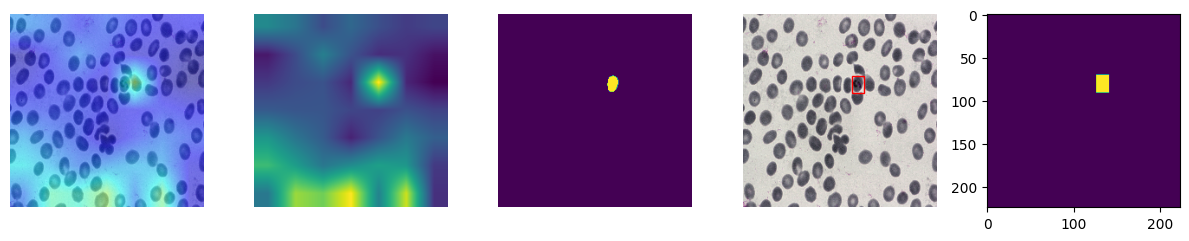

SAM Segmentation Results: 
AUC Judd:  0.87934087
AUPRC:0.014400605112314224

Dataset Bbox Segmentation Results: 
AUC Judd:  0.8809506850000001
AUPRC:0.02464701607823372
458cb2e9-5a7f-437c-ac5d-a56f98a3efdf.png


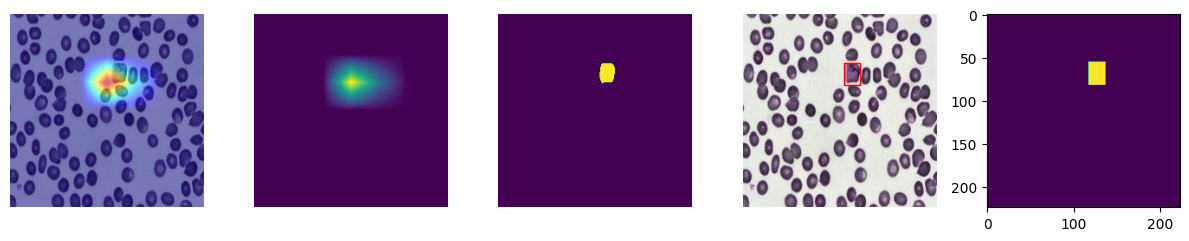

SAM Segmentation Results: 
AUC Judd:  0.98281981
AUPRC:0.16865718364715576

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9823019250000001
AUPRC:0.24484844505786896
461a3ed6-039f-4a70-97cf-c474ecf51ccd.png


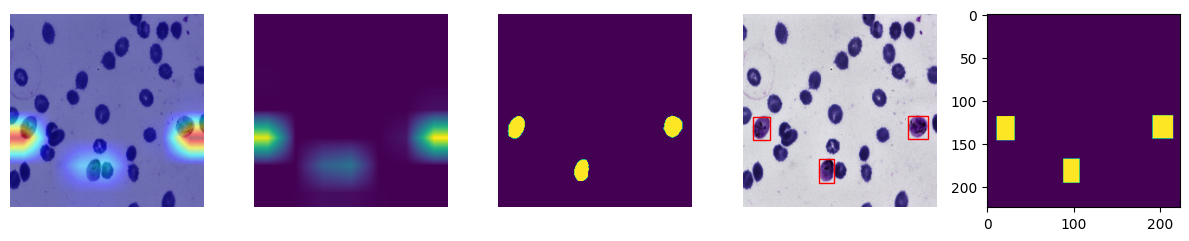

SAM Segmentation Results: 
AUC Judd:  0.9613379300000001
AUPRC:0.22111541032791138

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9649072449999999
AUPRC:0.3488861918449402
45902b63-be9a-49ae-9ede-3a8015671bc4.png


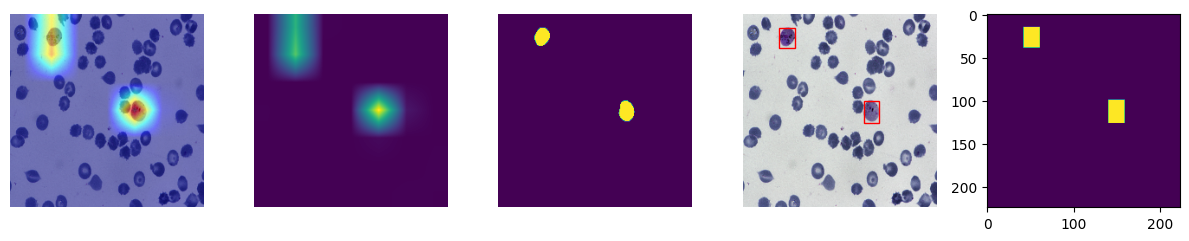

SAM Segmentation Results: 
AUC Judd:  0.99329064
AUPRC:0.6381298899650574

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9909762900000001
AUPRC:0.6397817730903625
46a03374-64c7-49ac-81c9-c3d62542bbf3.png


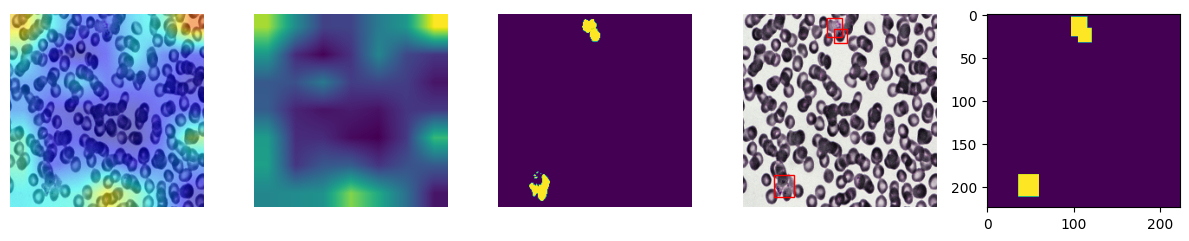

SAM Segmentation Results: 
AUC Judd:  0.578364985
AUPRC:0.016522957012057304

Dataset Bbox Segmentation Results: 
AUC Judd:  0.5599202649999999
AUPRC:0.025043100118637085
464055b6-3351-4636-a919-8be9840fb850.png


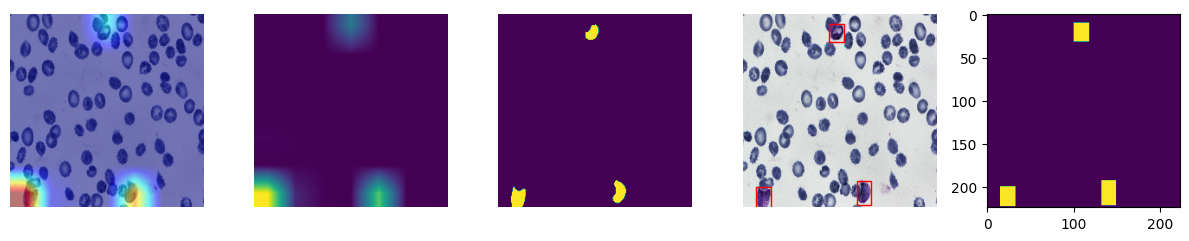

SAM Segmentation Results: 
AUC Judd:  0.9793150549999999
AUPRC:0.2998487055301666

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9786531250000001
AUPRC:0.39556822180747986
468c261d-f5d8-423f-883e-48af2bbbc5d1.png


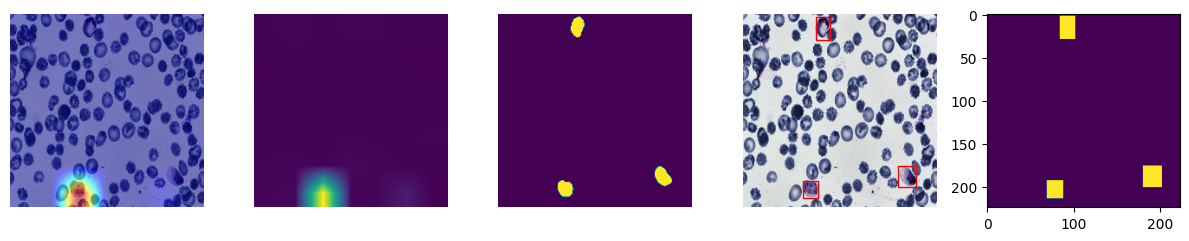

SAM Segmentation Results: 
AUC Judd:  0.816791805
AUPRC:0.1414460688829422

Dataset Bbox Segmentation Results: 
AUC Judd:  0.7728100149999999
AUPRC:0.17895501852035522
477e541c-0519-4542-9b13-8ee7922644d3.png


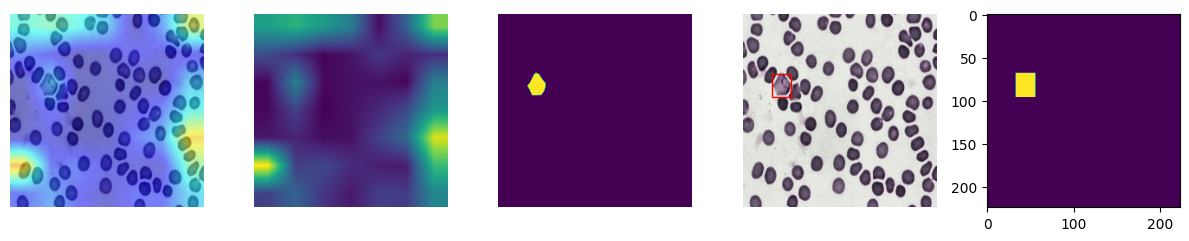

SAM Segmentation Results: 
AUC Judd:  0.74578778
AUPRC:0.013695498928427696

Dataset Bbox Segmentation Results: 
AUC Judd:  0.718605095
AUPRC:0.020933065563440323
47112c6b-aaf6-488d-8f3b-f9ed0cce9a95.jpg


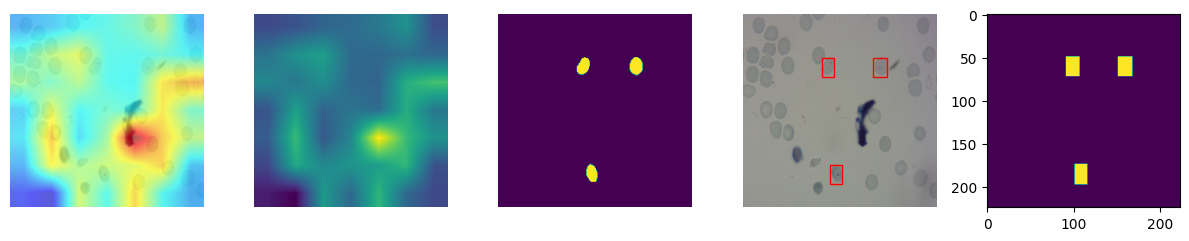

SAM Segmentation Results: 
AUC Judd:  0.538384725
AUPRC:0.01422638725489378

Dataset Bbox Segmentation Results: 
AUC Judd:  0.53530172
AUPRC:0.021588072180747986
46f5bd4f-8bea-48d1-a1da-4dea28e3b814.png


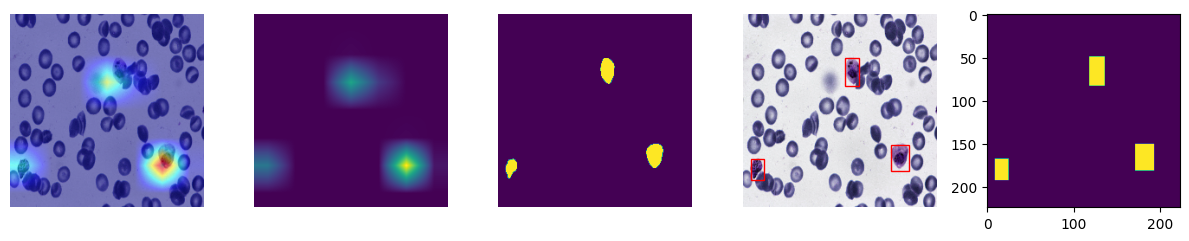

SAM Segmentation Results: 
AUC Judd:  0.9600597750000001
AUPRC:0.2608451843261719

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9612521549999999
AUPRC:0.4412654936313629
4767bfcc-fe87-4962-8c40-6ce8d9363cdf.png


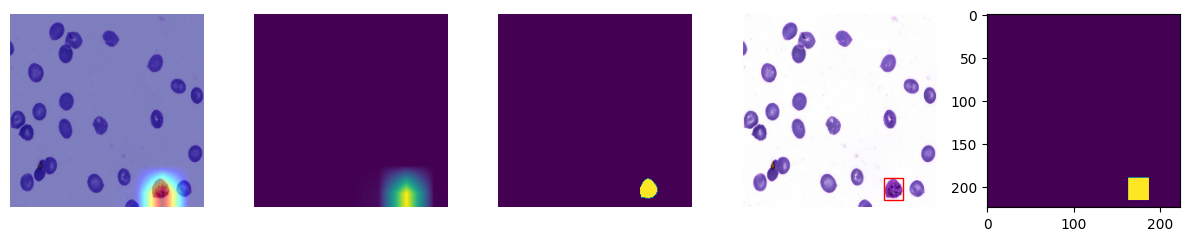

SAM Segmentation Results: 
AUC Judd:  0.995096245
AUPRC:0.41830959916114807

Dataset Bbox Segmentation Results: 
AUC Judd:  0.995223855
AUPRC:0.5776975154876709
471f75c6-bd5d-4c20-bcc1-258e836f4d69.png


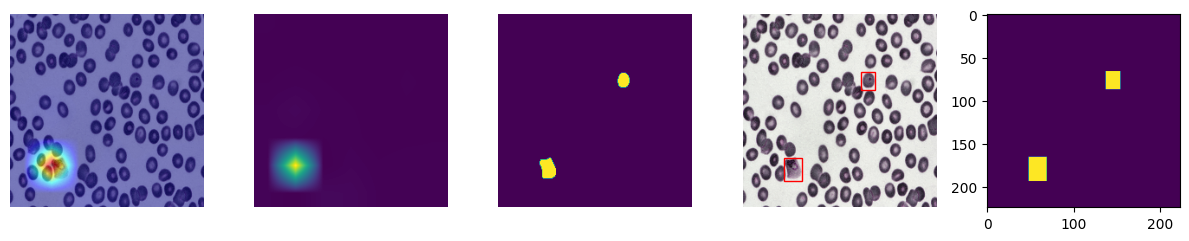

SAM Segmentation Results: 
AUC Judd:  0.651977
AUPRC:0.2218252718448639

Dataset Bbox Segmentation Results: 
AUC Judd:  0.6357633699999999
AUPRC:0.2796449065208435
4736f545-1f1f-4d77-9241-d69cbf4dae35.png


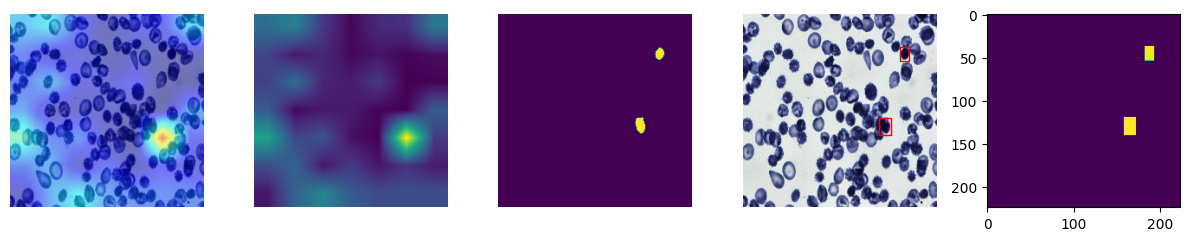

SAM Segmentation Results: 
AUC Judd:  0.5414551950000001
AUPRC:0.010907814837992191

Dataset Bbox Segmentation Results: 
AUC Judd:  0.56893745
AUPRC:0.026240849867463112
4811fdf2-d7e8-475e-a840-45dda5282bf3.png


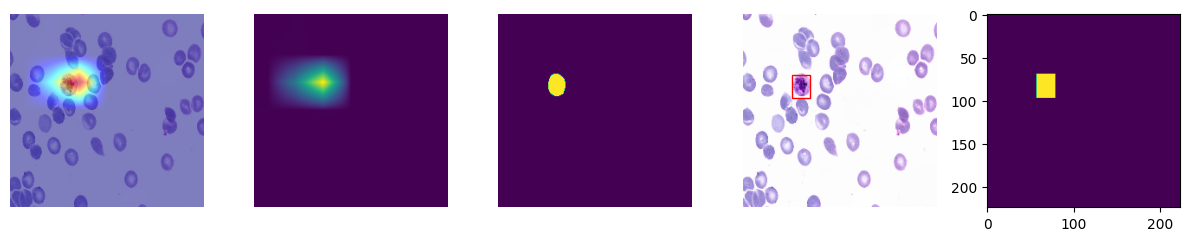

SAM Segmentation Results: 
AUC Judd:  0.9940336900000001
AUPRC:0.4210420250892639

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9933423899999999
AUPRC:0.513721227645874
4849866a-73a2-4fcf-a407-2d0a25a09a89.png


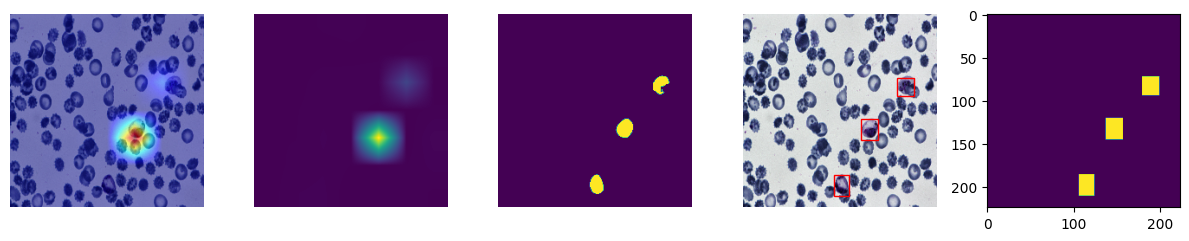

SAM Segmentation Results: 
AUC Judd:  0.6996454000000002
AUPRC:0.1763405203819275

Dataset Bbox Segmentation Results: 
AUC Judd:  0.70290277
AUPRC:0.2606731951236725
4876c9d0-b386-48fb-84e8-91bf87529161.png


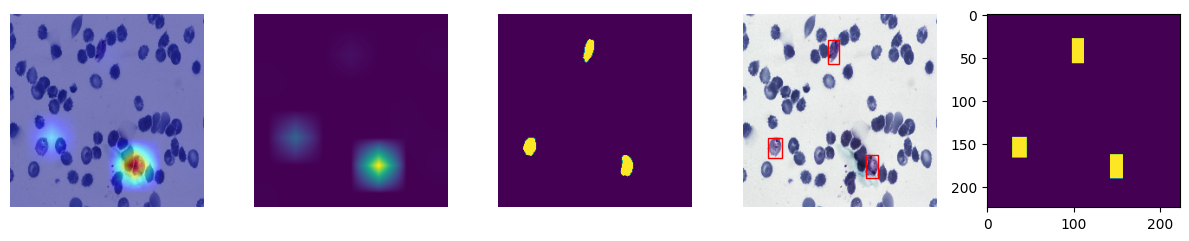

SAM Segmentation Results: 
AUC Judd:  0.94087816
AUPRC:0.30455219745635986

Dataset Bbox Segmentation Results: 
AUC Judd:  0.9387947449999999
AUPRC:0.33188462257385254
49b03a6e-6b26-4a96-a061-e05647a02138.png


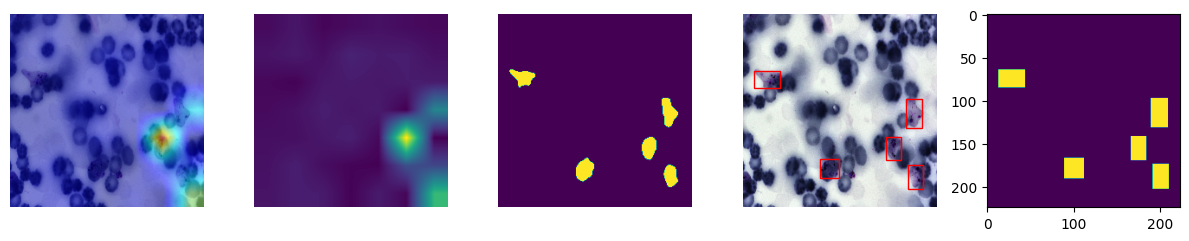

SAM Segmentation Results: 
AUC Judd:  0.59000187
AUPRC:0.16052556037902832

Dataset Bbox Segmentation Results: 
AUC Judd:  0.5990337149999999
AUPRC:0.22741387784481049
49288109-80e9-4ec8-96d1-26a0166b8883.png


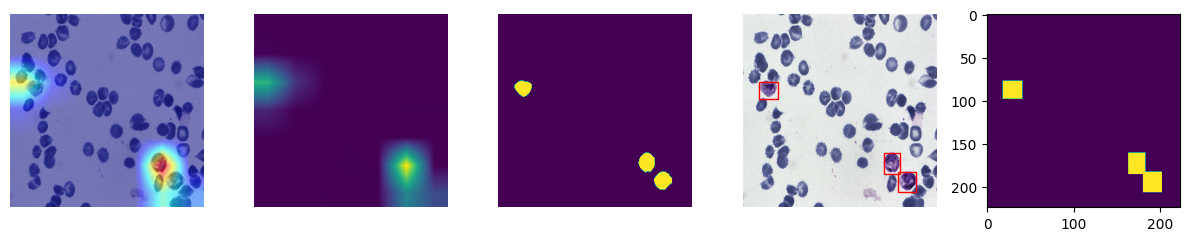

SAM Segmentation Results: 
AUC Judd:  0.9751141299999999
AUPRC:0.41668716073036194

Dataset Bbox Segmentation Results: 
AUC Judd:  0.973406165
AUPRC:0.5200877785682678


In [ ]:
import matplotlib.patches as patches

for data, datatype in malaria_data_in_malaria_sam[:25]:
  model_ft.eval()

  imgtransform = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  print(data)
  SAMimage = iptimage=Image.open(f"/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/malaria_SAM/{data}")
  iptimage=Image.open(f"/content/drive/Shareddrives/ACM Research Lab/Explainable CNN for Medical Project/data/CoolMalariaBox/malaria/images/{datatype}/Malaria/{data}").convert('RGB')
  img_np = np.array(iptimage)
  img_resized = cv2.resize(img_np, (224, 224))
  img_np = np.array(img_resized).astype(np.float32) / 255.0

  input_tensor = imgtransform(iptimage)
  input_tensor = input_tensor.unsqueeze(0) #add batch dimension
  target_layers = [model_ft.features[-1]]


  # Construct the CAM object once, and then re-use it on many images:
  cam = GradCAM(model=model_ft, target_layers=target_layers, use_cuda=True)
  grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True)
  grayscale_cam = grayscale_cam[0, :]

  visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
  #Image.fromarray(visualization)
  #Image.fromarray(img_resized)

  fig, axes = plt.subplots(1, 5, figsize=(12, 4))
  samimg = cv2.resize(np.array(SAMimage),(224,224))

  gt = samimg
  gt = np.where(gt > 1, 1, gt)
  
  gc_tensor = torch.tensor(grayscale_cam.flatten())
  gt_tensor = torch.tensor(gt.flatten())

  auprc = binary_auprc(gc_tensor, gt_tensor)

  pr_curve = PrecisionRecallCurve(task="binary")
  precision, recall, thresholds = pr_curve(gc_tensor, gt_tensor)

  #DISPLAY STUFF
  # Display the first image
  axes[0].imshow(visualization)
  axes[0].axis('off')

  # Display the second image
  axes[1].imshow(grayscale_cam)
  axes[1].axis('off')

  # Display the third image
  axes[2].imshow(samimg)
  axes[2].axis('off')

  # Display the fourth image
  axes[3].imshow(img_resized)
  axes[3].axis('off')

  bbox_list = annotations_dict[data]

  img_height = np.array(img_resized).shape[0]
  img_width = np.array(img_resized).shape[1]

  binary_map_bbox = np.zeros((img_height, img_width), dtype=int)

  for bbox in bbox_list:
        if bbox['category'] != 'red blood cell':
            x_ratio = 224 / size_dict[data]['c']
            y_ratio = 224 / size_dict[data]['r']

            x1 = round(bbox['bounding_box']["minimum"]["c"] * x_ratio)
            y1 = round(bbox['bounding_box']["minimum"]["r"] * y_ratio)
            x2 = round(bbox['bounding_box']["maximum"]["c"] * x_ratio)
            y2 = round(bbox['bounding_box']["maximum"]["r"] * y_ratio)

            for i in range(y1, min(y2 + 1, img_height - 1)):
                for j in range(x1, min(x2 + 1, img_width - 1)):
                    binary_map_bbox[i][j] = 1

            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
            axes[3].add_patch(rect)

  axes[4].imshow(binary_map_bbox)
    
  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the figure
  plt.show()
  print("SAM Segmentation Results: ")
  auc_judd(gt, grayscale_cam)
  print(f"AUPRC:{auprc.item()}")

  bbox_tensor = torch.tensor(binary_map_bbox.flatten())
  auprc = binary_auprc(gc_tensor, bbox_tensor)

  print()
  print("Dataset Bbox Segmentation Results: ")
  auc_judd(binary_map_bbox, grayscale_cam)
  print(f"AUPRC:{auprc.item()}")
